In [1]:
#Here we load Apple’s price data with indicators (moving averages, RSI, etc.) prepared earlier. This dataset is the foundation for our strategy testing.

import pandas as pd

# Load enriched price data
data = pd.read_csv("../data/AAPL_enriched.csv", index_col=0, parse_dates=True)


In [2]:
#This function simulates a moving average strategy but now deducts transaction costs (broker fees) and slippage (price impact when executing trades). Every time the strategy changes position, we subtract a small penalty to reflect realistic trading.

import numpy as np

def backtest_with_costs(df, fast=10, slow=50, cost_bp=10, slippage_bp=5):
    """
    cost_bp: transaction cost in basis points (0.01% = 1bp)
    slippage_bp: extra cost to simulate imperfect fills
    """
    temp = df.copy()
    temp[f"SMA_{fast}"] = temp["Close"].rolling(fast).mean()
    temp[f"SMA_{slow}"] = temp["Close"].rolling(slow).mean()
    
    # Generate signals: 1 = long, -1 = short
    temp["Signal"] = 0
    temp.loc[temp[f"SMA_{fast}"] > temp[f"SMA_{slow}"], "Signal"] = 1
    temp.loc[temp[f"SMA_{fast}"] < temp[f"SMA_{slow}"], "Signal"] = -1
    temp["Position"] = temp["Signal"].shift(1).fillna(0)
    
    # Daily returns
    temp["Return"] = temp["Close"].pct_change()
    temp["Strategy_Return"] = temp["Position"] * temp["Return"]
    
    # Apply transaction costs on position changes
    temp["Trade"] = temp["Position"].diff().abs()  # 2 = flip from long to short
    cost = (cost_bp + slippage_bp) / 10000
    temp["Strategy_Return"] -= temp["Trade"] * cost
    
    return temp



In [3]:
#We run two versions of the strategy: one assuming free trading, and one with realistic costs. This allows us to see how much performance erodes when fees are considered.

# No cost run
no_cost = backtest_with_costs(data, fast=10, slow=50, cost_bp=0, slippage_bp=0)

# With realistic costs: 10 bps transaction + 5 bps slippage
with_cost = backtest_with_costs(data, fast=10, slow=50, cost_bp=10, slippage_bp=5)



In [4]:
#We calculate standard performance metrics for both runs:

#CAGR (Compound Annual Growth Rate)

#Volatility (risk)

#Sharpe Ratio (risk-adjusted return)

#Max Drawdown (largest portfolio loss from a peak).

#Comparing the two shows how fees reduce strategy quality.

def compute_metrics(df):
    strat_curve = (1 + df["Strategy_Return"]).cumprod()
    years = (df.index[-1] - df.index[0]).days / 365.25
    cagr = strat_curve.iloc[-1]**(1/years) - 1
    vol = df["Strategy_Return"].std() * np.sqrt(252)
    sharpe = (df["Strategy_Return"].mean() * 252) / (df["Strategy_Return"].std() * np.sqrt(252))
    roll_max = strat_curve.cummax()
    dd = (strat_curve / roll_max - 1).min()
    return {"CAGR": cagr, "Volatility": vol, "Sharpe": sharpe, "MaxDD": dd}

metrics_no_cost = compute_metrics(no_cost)
metrics_with_cost = compute_metrics(with_cost)

metrics_no_cost, metrics_with_cost



({'CAGR': np.float64(-0.12185634208588725),
  'Volatility': np.float64(0.04124301625654238),
  'Sharpe': np.float64(-3.175535679227622),
  'MaxDD': np.float64(-0.026329927975329626)},
 {'CAGR': np.float64(-0.12833817333014008),
  'Volatility': np.float64(0.043640200794324485),
  'Sharpe': np.float64(-3.170939450981954),
  'MaxDD': np.float64(-0.027810032844322374)})

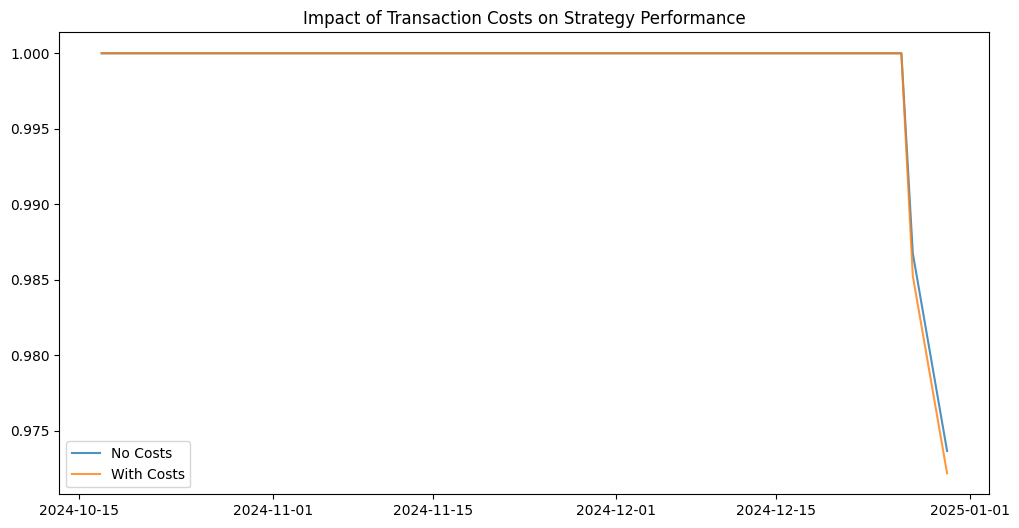

In [5]:
#The chart compares how the portfolio grows with and without costs. A gap between the two curves demonstrates the real-world drag from trading frictions.

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot((1 + no_cost["Strategy_Return"]).cumprod(), label="No Costs", alpha=0.8)
plt.plot((1 + with_cost["Strategy_Return"]).cumprod(), label="With Costs", alpha=0.8)
plt.title("Impact of Transaction Costs on Strategy Performance")
plt.legend()
plt.show()


In [6]:
#We save both the numeric results and a summary log. This creates an audit trail of experiments, important for reproducibility and transparency.

import os
from datetime import datetime

os.makedirs("../logs", exist_ok=True)

pd.DataFrame([metrics_no_cost, metrics_with_cost], index=["No Costs", "With Costs"]).to_csv("../logs/Day7_costs_comparison.csv")

with open("../logs/Day7_summary.txt", "w") as f:
    f.write(f"Day 7 run ({datetime.today().date()})\n")
    f.write("No Costs Metrics:\n")
    f.write(str(metrics_no_cost) + "\n")
    f.write("With Costs Metrics:\n")
    f.write(str(metrics_with_cost) + "\n")
